# Importing Packages

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Loading the Dataset

In [3]:
train_X = pd.read_csv("X_train.csv",header = None)
train_Y = pd.read_csv("y_train.csv",header = None)
test_X = pd.read_csv("X_test.csv",header = None)
test_Y = pd.read_csv("y_test.csv",header = None)
features = pd.read_csv("features.csv",header = None)
train_X.columns = features[0]
test_X.columns = features[0]
train_Y.columns = ['activity']
test_Y.columns = ['activity']

# Modelling

In [ ]:
#Naivebayes Classifier
kf = KFold(n_splits=5)
nb = GaussianNB()
nb.fit(train_X,train_Y)
y_prednb = nb.predict(test_X)

In [ ]:
# RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_X,train_Y)
y_predrfc = rfc.predict(test_X)

In [18]:
# Hyper Parameter using Grid Search for RFC
param_grid = { 
    'n_estimators': [100, 400],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
GS_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
GS_rfc.fit(test_X,test_Y)
print(GS_rfc.best_estimator_)
print(GS_rfc.best_params_)
print(GS_rfc.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 400}
0.9222938581608415


In [ ]:
#Support Vector Machine
svm = SVC(kernel="linear")
svm.fit(train_X,train_Y)
y_predsvm = svm.predict(test_X)

In [21]:
# Hyper Parameter using Grid Search for SVM
tuned_param = {
    'kernel' : ['linear'],
    'C' : [1, 10, 100, 1000]
}
GS_svm = GridSearchCV(svm, tuned_param)
GS_svm.fit(test_X,test_Y)
print(GS_svm.best_estimator_)
print(GS_svm.best_params_)
print(GS_svm.best_score_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
{'C': 1, 'kernel': 'linear'}
0.9399389209365456


# Evaluation

In [16]:
# Evaluation Naive Bayes Classifier
print("Accuracy:",metrics.accuracy_score(test_Y, y_prednb))
res_nb = cross_val_score(nb,train_X,train_Y, scoring='accuracy', cv=kf)
print("Cross_validation_score:", res_nb.mean()*100)

Accuracy: 0.7726501526976587
Cross_validation_score: 69.47896983402471


In [17]:
# Evaluation for Random Forest Classifier
print("Accuracy:",metrics.accuracy_score(test_Y, y_predrfc))
res_rfc = cross_val_score(rfc,train_X,train_Y, scoring='accuracy', cv=kf)
print("Cross_validation_score:",res_rfc.mean()*100)

Accuracy: 0.9267051238547676
Cross_validation_score: 91.11791229068106


In [20]:
# Evaluation for SVM
print("Accuracy:",metrics.accuracy_score(test_Y, y_predsvm))
res_svm = cross_val_score(svm,train_X,train_Y, scoring='accuracy', cv=kf)
print("Cross_validation_score:",res_svm.mean()*100)

Accuracy: 0.9640312181879878
Cross_validation_score: 93.86617461396524


## Evaluation using ROC and Confusion matrics

In [22]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [23]:
print("ROC_AUC_Score for naivebayes:",multiclass_roc_auc_score(test_Y,y_prednb))
print("ROC_AUC_Score for RandomForest:",multiclass_roc_auc_score(test_Y,y_predrfc))
print("ROC_AUC_Score for SVM:",multiclass_roc_auc_score(test_Y,y_predsvm))

ROC_AUC_Score for naivebayes: 0.8628007549074823
ROC_AUC_Score for RandomForest: 0.9544893381703843
ROC_AUC_Score for SVM: 0.9781725511270357


ROC_CURVE for Naive Bayes

In [24]:
#binarize th output
y = label_binarize(test_Y, classes=[1,2,3,4,5,6])
n_classes = y.shape[1]
y_score_nb = nb.fit(train_X,train_Y).predict_proba(test_X)

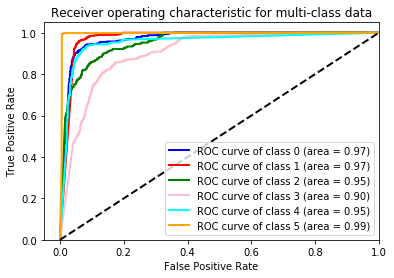

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score_nb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['blue', 'red', 'green','pink','aqua','orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

ROC_CURVE & Confusion matrix for Random Forest

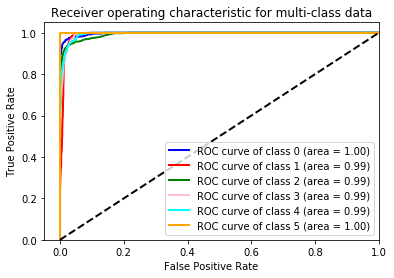

In [26]:
y_score_rfc = rfc.fit(train_X,train_Y).predict_proba(test_X)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score_rfc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['blue', 'red', 'green','pink','aqua','orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [27]:
y_truerfc, y_predrfc = test_Y, GS_rfc.predict(test_X)
print (classification_report(y_truerfc, y_predrfc))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       496
           2       1.00      1.00      1.00       471
           3       1.00      1.00      1.00       420
           4       1.00      0.99      1.00       491
           5       0.99      1.00      1.00       532
           6       1.00      1.00      1.00       537

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947



ROC_CURVE & Confusion matrix for SVM

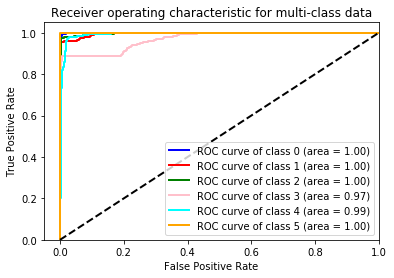

In [28]:
y_score_svm = svm.fit(train_X,train_Y).decision_function(test_X)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['blue', 'red', 'green','pink','aqua','orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [29]:
y_truesvm, y_predsvm = test_Y, GS_svm.predict(test_X)
print (classification_report(y_truesvm, y_predsvm))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       496
           2       1.00      1.00      1.00       471
           3       1.00      1.00      1.00       420
           4       0.99      0.99      0.99       491
           5       0.99      0.99      0.99       532
           6       1.00      1.00      1.00       537

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947

